# Decision Tree

### Datensatz einlesen

In [1]:
import geopandas as gpd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# für Visualisierung
import matplotlib.pyplot as plt

In [3]:
# GeoJSON-Datei laden
gdf = gpd.read_file('../../../data/processed_data/simra_osm_all.geojson')

In [4]:
gdf.head(2)

,id,type,score,incidents,rides,index_right,maxspeed,asphalt,concrete,paving_stone,...,highway_rare,living_street,path,primary,residential,secondary,service,tertiary,track,geometry
0,[100049].0,Street,0.0,0,138,57832.0,50,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,"POLYGON ((13.45412 52.54035, 13.45320 52.53977..."
1,[100069498].0,Junction,0.0,0,200,123443.0,30,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,"POLYGON ((13.52273 52.50704, 13.52248 52.50690..."


In [5]:
gdf.columns

Index(['id', 'type', 'score', 'incidents', 'rides', 'index_right', 'maxspeed',
       'asphalt', 'concrete', 'paving_stone', 'sett', 'unpaved', 'markers',
       'highway', 'cycleway', 'footway', 'highway_rare', 'living_street',
       'path', 'primary', 'residential', 'secondary', 'service', 'tertiary',
       'track', 'geometry'],
      dtype='object')

#### Geometrische und nicht relevante Daten entfernen:
- 'type' (juncton oder street) wird auch entfernt, da diese Informationen nicht in den OSM-Segmenten enthalten sind

In [6]:
df = gdf.drop(columns=['markers', 'id', 'index_right', 'geometry', 'highway', 'incidents', 'rides', 'type'])

In [7]:
df.head(2)

,score,maxspeed,asphalt,concrete,paving_stone,sett,unpaved,cycleway,footway,highway_rare,living_street,path,primary,residential,secondary,service,tertiary,track
0,0.0,50,0.0,1.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0
1,0.0,30,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0


### Feature- und Zielvariablen definieren

In [9]:
# Zielvariable (Score) definieren
y = df['score']

In [10]:
# Alle anderen Spalten als Features verwenden 
X = df.drop(columns=['score'])

### Trainings- und Testdaten splitten

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"Anzahl der Trainingsdaten: {X_train.shape[0]}")
print(f"Anzahl der Testdaten: {X_test.shape[0]}")

Anzahl der Trainingsdaten: 12529
Anzahl der Testdaten: 3133


## Modell initialisieren und trainieren

In [12]:
# Fit des Decision Tree Regressors, Training mit Baumtiefe 5
dt = DecisionTreeRegressor(max_depth=4)

In [13]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

### R²-Koeffizient (Bestimmtheitsmaß) des Entscheidungsbaum-Modells auf den Trainingsdaten

In [14]:
r2_train = dt.score(X_train, y_train)
r2_train

0.029940083785615745

### Visualsierung des Entscheidungsbaums

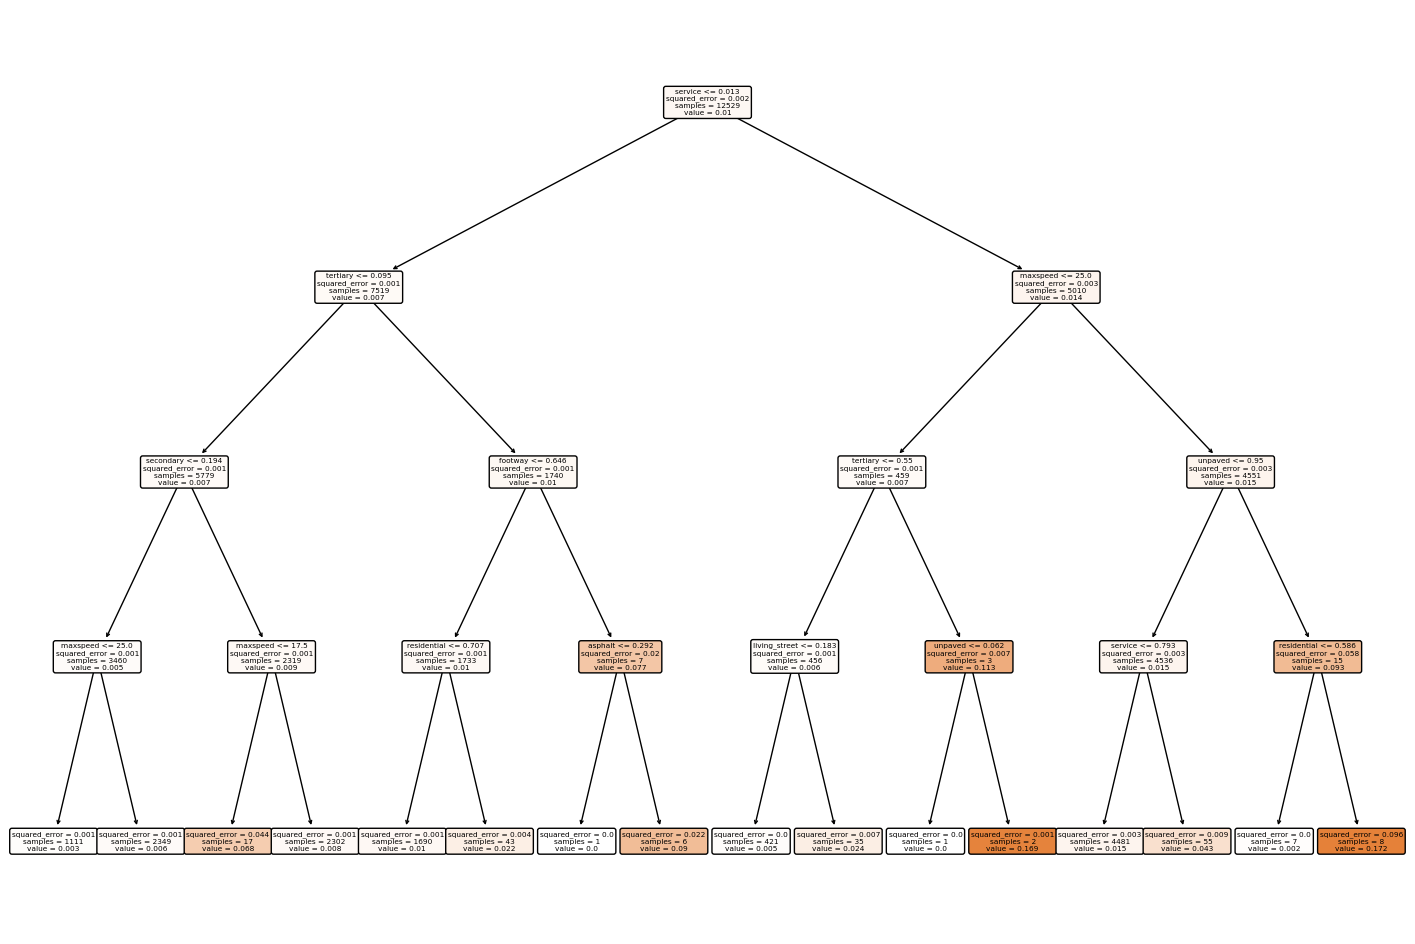

In [16]:
fig = plt.figure(figsize=(18,12))
_ = tree.plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)

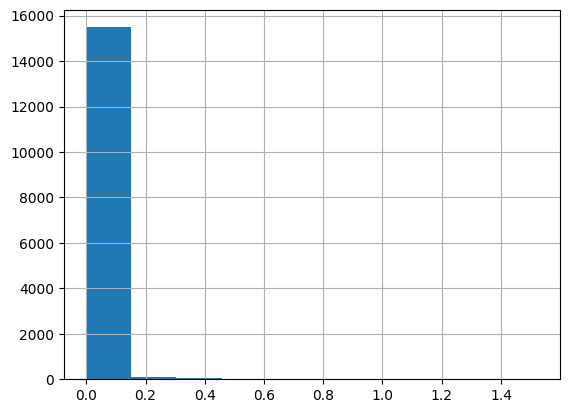

In [17]:
# Histogramm
df['score'].hist();

### Vorhersage auf den Testdaten

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, make_scorer

In [19]:
y_pred = dt.predict(X_test)

### Modellbewertung: MSE und R²-Score

In [20]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0025811846432834363


In [21]:
# R²-Score auf den Testdaten berechnen
r2 = r2_score(y_test, y_pred)
print(f'R²-Score auf den Testdaten: {r2}')

R²-Score auf den Testdaten: -0.005720672262463422


**Interpretation**: Ein R²-Score von -0,005 deutet darauf hin, dass das Modell die Variabilität in den Testdaten nicht gut erklärt und unzuverlässige Vorhersagen macht.

#### Feature Importance

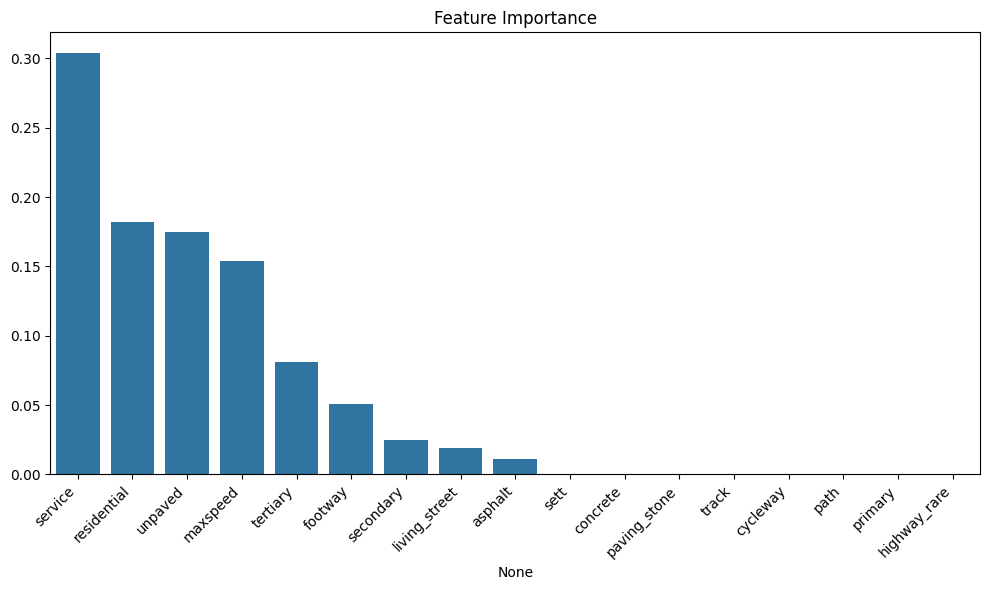

In [22]:
import numpy as np
import seaborn as sns

# Feature Importance extrahieren
importance = dt.feature_importances_

# Sortieren der Features nach Wichtigkeit
sorted_indices = np.argsort(importance)[::-1]

# Plot mit rotierter Achsenbeschriftung
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns[sorted_indices], y=importance[sorted_indices])
plt.xticks(rotation=45, ha='right')  # Beschriftung um 45 Grad rotieren
plt.title('Feature Importance')
plt.tight_layout()  # Automatische Anpassung des Layouts
plt.show()


# Hyperparamtertuning

### Hyperparameter-Raum definieren

- Hyperparameter festlegen, die optimiert werden sollen:

    - `max_depth`: Maximale Tiefe des Baums.
    - `min_samples_split`: Mindestanzahl von Samples, die notwendig sind, um einen Knoten zu teilen.
    - `min_samples_leaf`: Mindestanzahl von Samples in einem Blatt.
    - `max_features`: Maximale Anzahl von Features, die verwendet werden dürfen.

## Baumtiefe variieren & Fehlermetriken berechnen

#### Fehlermetriken:

- **`r2_score` (Bestimmtheitsmaß)**: Bestimmtheitsmaß, das die Güte der Anpassung des Modells angibt.
  - Ein Maß dafür, wie gut die Vorhersagen des Modells die Varianz in den tatsächlichen Zielwerten erklären.
  - Interpretation: Ein R^2-Score von 1 bedeutet perfekte Vorhersage, ein Wert von 0 bedeutet, dass das Modell nicht besser als der Mittelwert der Zielvariable ist. Negative Werte können auftreten, wenn das Modell schlechter ist als ein einfaches Modell, das immer den Mittelwert vorhersagt. R^2 zeigt an, wie gut das Modell die Zielvariabilität erklärt.
- **`mean_absolute_error`**: Durchschnittlicher absoluter Fehler.
  - Der Durchschnitt der absoluten Unterschiede zwischen den vorhergesagten Werten und den tatsächlichen Werten.
  - Interpretation: MAE gibt den durchschnittlichen absoluten Fehler des Modells in den gleichen Einheiten wie die Zielvariable an. Ein niedriger MAE bedeutet, dass das Modell im Durchschnitt geringe Fehler macht. MAE ist robust gegenüber Ausreißern, da alle Fehler gleich gewichtet werden.
- **`mean_squared_error`**: Durchschnittlicher quadratischer Fehler.
  - Der Durchschnitt der quadratischen Unterschiede zwischen den vorhergesagten Werten und den tatsächlichen Werten.
  - Interpretation: MSE bestraft größere Fehler stärker als kleinere Fehler, da die Fehlerquadrate verwendet werden. Ein niedriger MSE zeigt eine gute Modellanpassung an. MSE kann jedoch empfindlich gegenüber Ausreißern sein, da große Fehler quadratisch stärker gewichtet werden.
- **`root_mean_squared_error` sqrt von MSE**: Wurzel des mittleren quadratischen Fehlers (RMSE).
  - Die Quadratwurzel des Mittelwerts der quadratischen Fehler (MSE).
  - Interpretation: RMSE gibt die durchschnittliche Abweichung der Vorhersagen in den gleichen Einheiten wie die Zielvariable an. Es ist leichter zu interpretieren als der MSE, da es die Fehler in der gleichen Einheit wie die Zielvariable zurückgibt. RMSE ist ebenfalls empfindlich gegenüber großen Fehlern.
- **`median_absolute_error`**: Median des absoluten Fehlers.
  - Der Median der absoluten Fehler zwischen den Vorhersagen und den tatsächlichen Werten.
  - Interpretation: MedAE ist robust gegenüber Ausreißern, da es der Median der Fehler ist und nicht durch extreme Fehlerwerte beeinflusst wird. Es zeigt die zentrale Tendenz der Fehlerverteilung an, ohne dass große Fehler das Ergebnis dominieren.

In [24]:
# Cross-Validation für verschiedene Baumtiefen
depths = range(1, 21)  # Baumtiefen von 1 bis 20
mean_r2_scores = []
mean_mae_scores = []

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=1)
    model.fit(X_train, y_train)
    
    # Vorhersagen auf dem Testdatensatz
    y_pred = model.predict(X_test)
    
    # Fehlermetriken berechnen
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    medae = median_absolute_error(y_test, y_pred)
    
    # Ergebnisse für jede Tiefe speichern
    mean_r2_scores.append(r2)
    mean_mae_scores.append(mae)
    
    # Optional: Ergebnisse ausgeben
    print(f"Max Depth: {depth}")
    print(f"  R^2 Score: {r2:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Median Absolute Error (MedAE): {medae:.4f}")
    print("-" * 40)

Max Depth: 1
  R^2 Score: 0.0015
  Mean Absolute Error (MAE): 0.0158
  Mean Squared Error (MSE): 0.0026
  Root Mean Squared Error (RMSE): 0.0506
  Median Absolute Error (MedAE): 0.0075
----------------------------------------
Max Depth: 2
  R^2 Score: 0.0003
  Mean Absolute Error (MAE): 0.0158
  Mean Squared Error (MSE): 0.0026
  Root Mean Squared Error (RMSE): 0.0507
  Median Absolute Error (MedAE): 0.0068
----------------------------------------
Max Depth: 3
  R^2 Score: -0.0000
  Mean Absolute Error (MAE): 0.0158
  Mean Squared Error (MSE): 0.0026
  Root Mean Squared Error (RMSE): 0.0507
  Median Absolute Error (MedAE): 0.0086
----------------------------------------
Max Depth: 4
  R^2 Score: -0.0057
  Mean Absolute Error (MAE): 0.0157
  Mean Squared Error (MSE): 0.0026
  Root Mean Squared Error (RMSE): 0.0508
  Median Absolute Error (MedAE): 0.0082
----------------------------------------
Max Depth: 5
  R^2 Score: -0.0058
  Mean Absolute Error (MAE): 0.0156
  Mean Squared Error (MS

### Tree Depth vs. Performance

    Ein Performance-Plot, der die Tiefe des Entscheidungsbaums im Verhältnis zur Modellgüte zeigt, kann genutzt werden, um Überanpassung (Overfitting) zu identifizieren

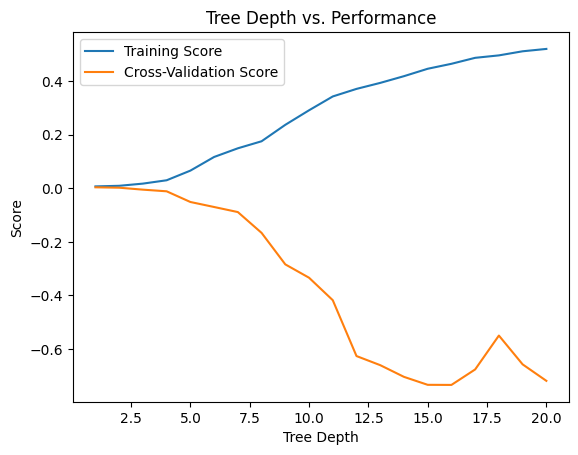

In [25]:
from sklearn.model_selection import cross_val_score

depths = np.arange(1, 21)
train_scores = []
test_scores = []

for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))
    test_scores.append(np.mean(cross_val_score(dt, X_train, y_train, cv=5)))

plt.plot(depths, train_scores, label='Training Score')
plt.plot(depths, test_scores, label='Cross-Validation Score')
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('Tree Depth vs. Performance')
plt.legend()
plt.show()

Interpretation:

- Zeigt, wie die Leistung des Modells mit der Baumtiefe variiert.
- Ein zu tiefes Modell kann überfitted sein (hoher Trainings-Score, niedriger CV-Score).

##  k-fache Cross-Validation (mit 5 Folds)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

# Definiere das Modell
dt = DecisionTreeRegressor(max_depth=4)

# Definiere die Scoring-Metriken
scoring = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(root_mean_squared_error)
}

# Führe die Cross-Validation durch (5 Folds)
cv_results = cross_validate(dt, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Durchschnittliche Ergebnisse der Cross-Validation anzeigen
print("Durchschnittliche Ergebnisse über die 5 Folds:")
print(f"R^2 Score: {cv_results['test_R2'].mean()}")
print(f"Mean Absolute Error (MAE): {cv_results['test_MAE'].mean()}")
print(f"Mean Squared Error (MSE): {cv_results['test_MSE'].mean()}")
print(f"Root Mean Squared Error (RMSE): {cv_results['test_RMSE'].mean()}")


Durchschnittliche Ergebnisse über die 5 Folds:
R^2 Score: -0.011249172962073683
Mean Absolute Error (MAE): 0.015109786396713953
Mean Squared Error (MSE): 0.0016972056687534307
Root Mean Squared Error (RMSE): 0.04095732270977322


### Hyperparametertuning

Im Fall eines Entscheidungsbaum-Regressors gibt es mehrere Hyperparameter, die optimiert werden können:

- `max_depth`: Maximale Tiefe des Baums. Tiefe Bäume können zu Overfitting führen, während flache Bäume zu Underfitting neigen.
- `min_samples_split`: Mindestanzahl an Samples, die benötigt werden, um einen Knoten zu teilen. Kleinere Werte erlauben mehr Teilungen und komplexere Bäume.
- `min_samples_leaf`: Mindestanzahl an Samples, die in einem Blattknoten vorhanden sein müssen.
- `max_features`: Anzahl der Features, die der Baum in jedem Split in Betracht zieht.

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Definiere das Modell
model = DecisionTreeRegressor()

# Definiere den Hyperparameter-Raum (inklusive max_features)
param_grid = {
    'max_depth': range(1, 21),  # Baumtiefen
    'min_samples_split': [2, 5, 10, 20],  # minimale Anzahl an Samples für Splits
    'min_samples_leaf': [1, 2, 4, 10],  # minimale Anzahl an Samples in einem Blatt
    'max_features': [None, 'sqrt', 'log2', 0.5]  # Werte für max_features
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 21),
                         'max_features': [None, 'sqrt', 'log2', 0.5],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='r2')

In [26]:
# Bestes Modell und Parameter
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Score: {grid_search.best_score_}")
print(f"Best Params: {best_params}")

Best Score: 0.01096592105406904
Best Params: {'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20}


#### Interpretation: 
Der negative `Best Score` von -0.0086 (R²-Score) zeigt an, dass das Modell unter diesen Hyperparameter-Einstellungen keinen guten `R²`-Wert liefert und fast keine Varianz der Zielvariablen erklärt. Das Modell schneidet schlechter ab als ein einfaches Modell, das immer den Mittelwert der Zielvariable vorhersagt.

### Cross Validation auf Trainingsdaten

In [27]:
from sklearn.model_selection import cross_validate

# Cross-Validation auf Trainingsdaten
scoring = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)))
}

cv_results = cross_validate(grid_search.best_estimator_, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

print("Durchschnittliche Ergebnisse über die 5 Folds:")
print(f"R^2 Score: {cv_results['test_R2'].mean()}")
print(f"Mean Absolute Error (MAE): {cv_results['test_MAE'].mean()}")
print(f"Mean Squared Error (MSE): {cv_results['test_MSE'].mean()}")
print(f"Root Mean Squared Error (RMSE): {cv_results['test_RMSE'].mean()}")

Durchschnittliche Ergebnisse über die 5 Folds:
R^2 Score: 0.0018767176518486694
Mean Absolute Error (MAE): 0.015166587654915223
Mean Squared Error (MSE): 0.0016766682061048585
Root Mean Squared Error (RMSE): 0.040700577319459565


#### Bewertung auf den Testdaten

In [28]:
# Bewertung auf den Testdaten
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\nBewertung auf den Testdaten:")
print(f'Mean Squared Error: {mse}')
print(f'R²-Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Median Absolute Error: {median_ae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Bewertung auf den Testdaten:
Mean Squared Error: 0.002564200630998749
R²-Score: 0.0008968985870754231
Mean Absolute Error (MAE): 0.015754066414284153
Median Absolute Error: 0.007972709477774665
Root Mean Squared Error (RMSE): 0.050637936677936916


#### Warum könnte das Modell schlecht performen?

- Entscheidungsbaum-Komplexität: Ein Entscheidungsbaum ist möglicherweise nicht flexibel oder leistungsfähig genug, um die Struktur in deinen Daten korrekt zu erfassen.
- Datensatz: Wenn der Datensatz Rauschen oder wenig starke Korrelationen zwischen den Features und dem Zielwert enthält, könnte das Modell Schwierigkeiten haben, gute Vorhersagen zu treffen.
- Hyperparameter: Obwohl du Hyperparameter-Tuning durchgeführt hast, sind die optimalen Parameter möglicherweise immer noch nicht ideal oder das Modell ist zu stark regularisiert.
- Feature Engineering: Möglicherweise brauchst du zusätzliche Schritte im Feature Engineering, wie Skalierung, Transformationen oder neue Features, um das Modell zu verbessern.

#### Nächste Schritte:

Andere Modelle ausprobieren: Ein Entscheidungsbaum kann in manchen Fällen eingeschränkt sein. Komplexere Modelle wie Random Forests oder Gradient Boosting Machines (GBM) ausprobieren &rarr; könnten besser performen, indem sie mehrere Bäume kombinieren. Oder auch Lineare regression oder knn.

### Skalierung oder Transformation der Zielvariable

Bei der Verwendung von Entscheidungsbäumen wie dem DecisionTreeRegressor ist die Notwendigkeit zur Skalierung oder Transformation der Zielvariablen weniger ausgeprägt. Entscheidungsbäume sind nicht besonders anfällig für die Skalierung der Zielvariablen, da sie auf Basis von Splits in den Eingabefeatures arbeiten und nicht direkt von der Skala der Zielvariablen beeinflusst werden.

Jedoch können Transformationen der Zielvariablen in bestimmten Fällen hilfreich sein, insbesondere wenn mit einer sehr schiefen Verteilung der Zielvariablen umgegangen werden soll.

Eine mögliche Transfomation für Entscheidungsbäume:
#### Log-Transformation
- Wann anwenden: Wenn die Zielvariable stark schief verteilt ist und große Ausreißer oder hohe Werte aufweist. Die Log-Transformation kann helfen, die Verteilung zu normalisieren.
- Transformation:
    - y_log = np.log1p(y) (Log-Transformation mit np.log1p, um log(1 + y) zu verwenden und negative Werte zu vermeiden.)
    - Rücktransformation: Nach der Vorhersage, wird `np.expm1(pred)` für die Rücktransformation der Vorhersagen verwendet.
- Vorteil: Reduziert die Auswirkungen extremer Werte und kann die Modellleistung verbessern, wenn die Zielvariable eine starke Schiefe aufweist.

In [30]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Beispiel-Daten
# X, y = deine Daten

# Log-Transformation der Zielvariable
y_log = np.log1p(y)  # np.log1p(y) ist log(1 + y), um negative Werte zu vermeiden

# Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=1)

# Modell trainieren
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)

# Vorhersagen und Rücktransformation
y_pred_log = dt.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Rücktransformation der Vorhersagen

# Metriken berechnen
print(f"R^2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred))}")

R^2 Score: -0.00030719289451530685
Mean Absolute Error (MAE): 0.01437170517759776
Mean Squared Error (MSE): 0.0015010075669429916
Root Mean Squared Error (RMSE): 0.03874283891176525
